https://blog.csdn.net/qq_39516859/article/details/81705010

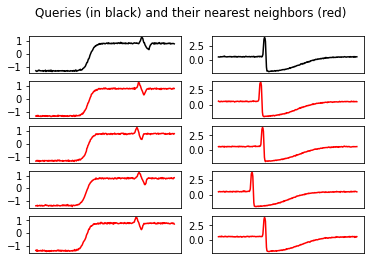

In [1]:
import numpy
import matplotlib.pyplot as plt

from tslearn.neighbors import KNeighborsTimeSeries
from tslearn.datasets import CachedDatasets

seed = 0
numpy.random.seed(seed)
X_train, y_train, X_test, y_test = CachedDatasets().load_dataset("Trace")
n_queries = 2
n_neighbors = 4

knn = KNeighborsTimeSeries(n_neighbors=n_neighbors)
knn.fit(X_train)
ind = knn.kneighbors(X_test[:n_queries], return_distance=True)
# #距离
# print(ind[0])
# #对应的数组
# print(ind[1])
plt.figure()
for idx_ts in range(n_queries):
    plt.subplot(n_neighbors + 1, n_queries, idx_ts + 1)
    plt.plot(X_test[idx_ts].ravel(), "k-")
    plt.xticks([])
    for rank_nn in range(n_neighbors):
        plt.subplot(n_neighbors + 1, n_queries,
                    idx_ts + (n_queries * (rank_nn + 1)) + 1)
        plt.plot(X_train[ind[1][idx_ts, rank_nn]].ravel(), "r-")
        plt.xticks([])


plt.suptitle("Queries (in black) and their nearest neighbors (red)")
plt.show()

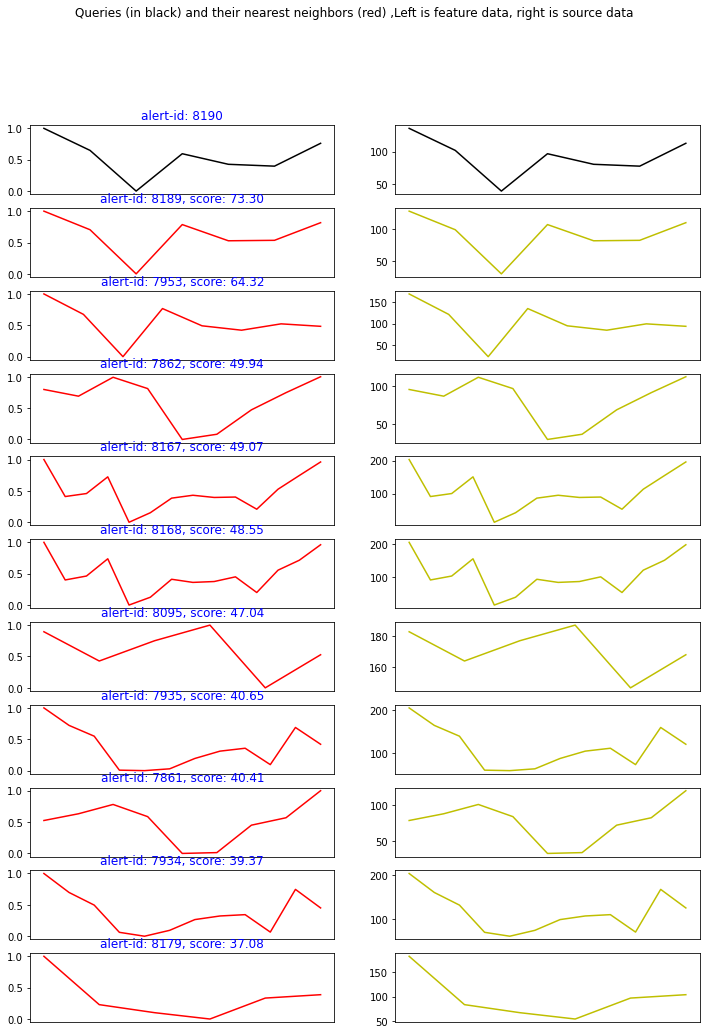

In [8]:
import numpy
import matplotlib.pyplot as plt
from tslearn.neighbors import KNeighborsTimeSeries
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMinMax
from tslearn.utils import to_time_series_dataset
import os, requests, json
def handle_ts_data_length(data, length):
    return data[:length]
def handle_alert_data(data):
    data = data['data']
    alertInfos = data[0]['alertRelatedInfos']
    alertIdList = []
    alertTsValues = []
    alertIdI = data[0]['alertId']
    alertITs = []
    for item in alertInfos:
        alertId = item['alertId']
        tsvalue = item['sensorValue']['values']
        tsvalue = handle_ts_data_length(tsvalue, 1000)
        if (alertIdI == alertId) :
            alertITs.append(tsvalue)
        else:
            alertIdList.append(alertId)
            alertTsValues.append(tsvalue)

    return alertITs, alertIdList, alertTsValues

def get_data(alert_id):
    url = 'http://10.192.30.68/gateway/dpp-core/v2/third-party/alert/details'
    s = json.dumps({'alertIds': [alert_id]})
    r = requests.post(url, data=s, headers = {"Content-Type": "application/json"})
    return json.loads(r.text)

def transform_data(data):
    res = []
    for x in data:
        z = float(x)
        res.append(z)
    return res

alert_id = 8190
data = get_data(alert_id)
alertITs, alertIdList, alertTsValues= handle_alert_data(data)
alert_len = len(alertIdList)
n_neighbors = 10
X = to_time_series_dataset(alertTsValues)
X_train = TimeSeriesScalerMinMax().fit_transform(X)
X_test = TimeSeriesScalerMinMax().fit_transform(to_time_series_dataset(alertITs))
knn = KNeighborsTimeSeries(n_neighbors=n_neighbors,metric="dtw")
knn.fit(X_train)
ind = knn.kneighbors(X_test, return_distance=True)
#距离
# print(ind[0])
# #对应的数组下标
# print(ind[1])

plt.figure(figsize=(12, 16.5))
plt.subplot(n_neighbors + 1, 2, 1)
plt.plot(X_test.ravel(), "k-")
plt.title("alert-id: " + str(alert_id), {'color':'blue'})
plt.xticks([])

plt.subplot(n_neighbors + 1, 2, 2)
plt.plot(transform_data(alertITs[0]), "k-")
plt.xticks([])
for rank_nn in range(n_neighbors):
    plt.subplot(n_neighbors + 1, 2, rank_nn * 2 + 3 )
    paid = alertIdList[ind[1][0][rank_nn]]
    pascore = format(100 - (ind[0][0][rank_nn] * 100), '.2f')
    title = "alert-id: " + str(paid) + ", score: " + str(pascore)
    plt.plot(X_train[ind[1][0, rank_nn]].ravel(), "r-")
    plt.title(title, {'color':'blue'})
    plt.xticks([])
    
    plt.subplot(n_neighbors + 1, 2, rank_nn * 2 + 4 )
    itts = alertTsValues[ind[1][0][rank_nn]]
    plt.plot(transform_data(itts), "y-")
    plt.xticks([])


plt.suptitle("Queries (in black) and their nearest neighbors (red) ,Left is feature data, right is source data")
plt.show()
#plt.savefig('1.png')
